In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import utils
import forward_model
import globals
import gradient_descent
import least_squares
import section_search
import coordinate_descent
import initialization

import torch

cuda
tensor([[1.3899, 1.3899, 1.3900,  ..., 1.8624, 1.8626, 1.8627],
        [1.3895, 1.3896, 1.3894,  ..., 1.8628, 1.8632, 1.8632],
        [1.3883, 1.3890, 1.3888,  ..., 1.8648, 1.8658, 1.8663],
        ...,
        [0.9879, 0.9882, 0.9884,  ..., 1.3799, 1.3799, 1.3799],
        [1.0255, 1.0262, 1.0269,  ..., 1.3797, 1.3797, 1.3797],
        [1.0256, 1.0262, 1.0269,  ..., 1.3797, 1.3797, 1.3797]])


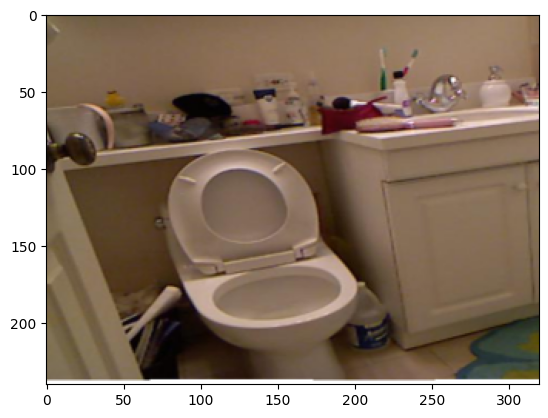

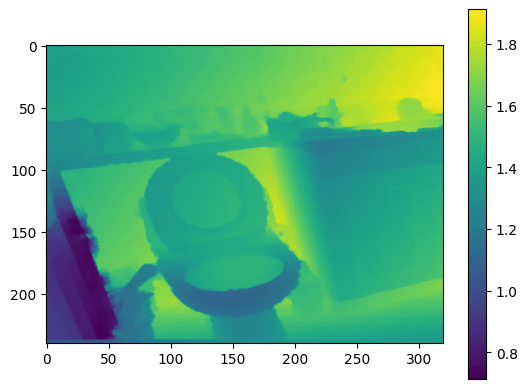

In [2]:
globals.init_NYUv2()

# EXPERIMENT_NAME = 'coord-descent-bracket-search'
# experiment_folder = utils.create_experiment_folder(EXPERIMENT_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# load data 
# gt_aif, gt_dpt = utils.load_single_sample(sample='0001', set='test', fs=5, res='half')
gt_aif, gt_dpt, gt_defocus_stack = utils.load_sample_image(fs=5, res='half')
print(gt_dpt)

plt.imshow(gt_aif)
plt.show()

plt.imshow(gt_dpt)
plt.colorbar()
plt.show()

width, height = gt_dpt.shape

# max_kernel_size = utils.kernel_size_heuristic(width, height)
# print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(7)

240 320
r tensor([ 2.2118,  6.6636, 10.1160, 12.0170, 13.0607])
doing edge overflow
kernel at 214, 54
tensor([[0.1589, 0.2648, 0.3599, 0.3986, 0.3599, 0.2648, 0.1589],
        [0.2648, 0.4415, 0.5999, 0.6644, 0.5999, 0.4415, 0.2648],
        [0.3599, 0.5999, 0.8151, 0.9028, 0.8151, 0.5999, 0.3599],
        [0.3986, 0.6644, 0.9028, 1.0000, 0.9028, 0.6644, 0.3986],
        [0.3599, 0.5999, 0.8151, 0.9028, 0.8151, 0.5999, 0.3599],
        [0.2648, 0.4415, 0.5999, 0.6644, 0.5999, 0.4415, 0.2648],
        [0.1589, 0.2648, 0.3599, 0.3986, 0.3599, 0.2648, 0.1589]])
r= tensor([[2.2118]])
(AFTER NORM) kernel at 214, 54
tensor([[0.0065, 0.0109, 0.0148, 0.0164, 0.0148, 0.0109, 0.0065],
        [0.0109, 0.0182, 0.0247, 0.0273, 0.0247, 0.0182, 0.0109],
        [0.0148, 0.0247, 0.0335, 0.0371, 0.0335, 0.0247, 0.0148],
        [0.0164, 0.0273, 0.0371, 0.0411, 0.0371, 0.0273, 0.0164],
        [0.0148, 0.0247, 0.0335, 0.0371, 0.0335, 0.0247, 0.0148],
        [0.0109, 0.0182, 0.0247, 0.0273, 0.0247, 0.0

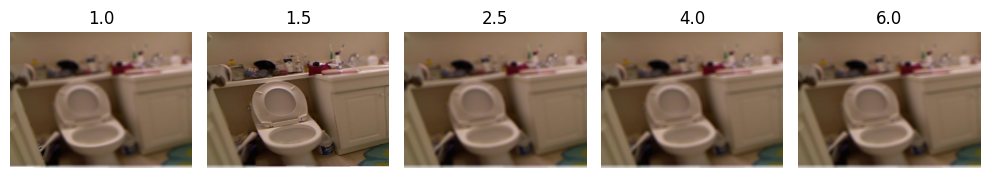

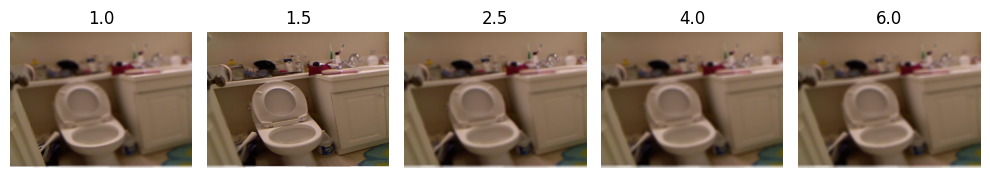

tensor(0.) tensor(1.)
result pixel [0-255] tensor([0.3218, 0.2635, 0.1948])
tensor(0.) tensor(1.)
result pixel [0-255] tensor([0.3190, 0.2607, 0.1949])
tensor(0.0054) tensor(0.9003)
result pixel [0-255] tensor([0.3187, 0.2605, 0.1949])
tensor(0.0057) tensor(0.8920)
result pixel [0-255] tensor([0.3187, 0.2604, 0.1948])
tensor(0.0057) tensor(0.8900)
result pixel [0-255] tensor([0.3187, 0.2604, 0.1948])


In [3]:
# forward model (torch)
FORWARD_KERNEL_TYPE = 'gaussian'
defocus_stack = forward_model.forward(gt_dpt, gt_aif, kernel=FORWARD_KERNEL_TYPE)
defocus_stack_torch = forward_model.forward_torch(gt_dpt, gt_aif, kernel=FORWARD_KERNEL_TYPE)#.float() / 255.0)
utils.plot_single_stack(defocus_stack_torch, globals.Df)

utils.plot_single_stack(gt_defocus_stack, globals.Df)
for defocus in defocus_stack_torch:
    print(defocus.min(), defocus.max())
    print('result pixel [0-255]',defocus[214,54,:])

In [4]:
import cv2
files = os.listdir(os.path.join('..','test_vWeights[index]'))
files = sorted(files)
gt_defocus_stack_v2 = [cv2.cvtColor(cv2.imread(os.path.join('..','test_vWeights[index]',file)), cv2.COLOR_BGR2RGB) for file in files]

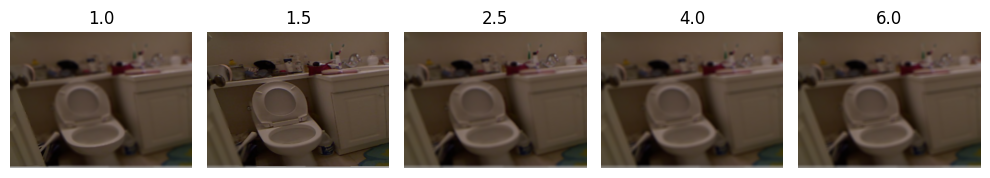

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..40.589336].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..61.31671].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..34.83729].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..11.540629].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6.9906616].


MSE 8.541697
MSE 1.3507560763888888


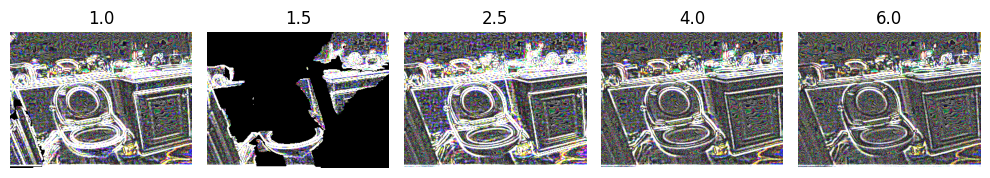

In [5]:
utils.plot_single_stack(np.stack(gt_defocus_stack_v2)/255., globals.Df, recon_max=1.5)

diff = abs(np.stack(gt_defocus_stack_v2) - defocus_stack_torch.numpy()*255.)

print('MSE',np.mean((np.stack(gt_defocus_stack_v2) - defocus_stack_torch.numpy()*255.) ** 2))

print('MSE',np.mean((np.stack(gt_defocus_stack_v2) - np.stack(gt_defocus_stack)) ** 2))

utils.plot_single_stack(diff, globals.Df, recon_max=1.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..44.669415].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..61.31671].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..34.83729].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..23.288239].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..21.334106].


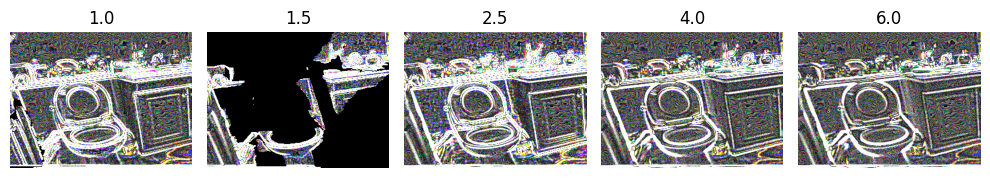

0.0 91.97507
[[1.6044998e+00 8.8193512e-01 2.5627136e-02]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [6.4328003e-01 9.2745972e-01 9.1552734e-04]
 [7.3474884e-01 1.0345078e+00 6.6062927e-02]
 [7.5633240e-01 1.0596313e+00 8.2008362e-02]]
[(np.int64(1), np.int64(237), np.int64(110), np.int64(2)), (np.int64(1), np.int64(237), np.int64(111), np.int64(2)), (np.int64(1), np.int64(237), np.int64(109), np.int64(2)), (np.int64(1), np.int64(237), np.int64(112), np.int64(2)), (np.int64(1), np.int64(237), np.int64(108), np.int64(2)), (np.int64(1), np.int64(237), np.int64(113), np.int64(2)), (np.int64(1), np.int64(237), np.int64(88), np.int64(2)), (np.int64(1), np.int64(237), np.int64(114), np.int64(2)), (np.int64(1), np.int64(237), np.int64(118), np.int64(2)), (np.int64(1), np.int64(237), np.int64(117), np.int64(2)), (np.int64(1), np.int64(237), np.int64(115), np.int64(2)), (np.int64(1), np.int64(237), np.int64(119), np.int64(2)), (np.int64(1), np.int64(237), np.int64(116), np.int64(2)), (np.int

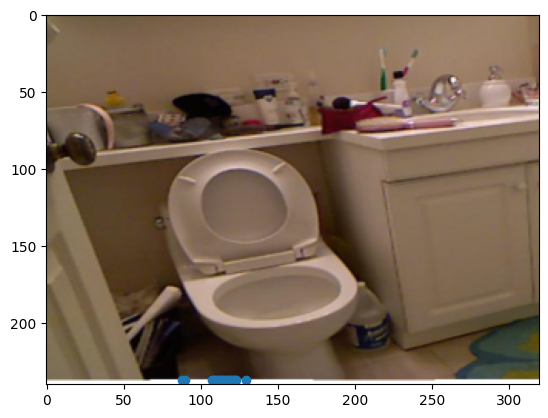

MSE 10.319433


In [6]:
# print(np.stack(gt_defocus_stack).shape, defocus_stack.shape)
diff = abs(np.stack(gt_defocus_stack) - defocus_stack*255.)
utils.plot_single_stack(diff, globals.Df, recon_max=1.5)

print(diff.min(), diff.max())
print(diff[:,0,0])

top_indices = np.argsort(diff.ravel())[::-1][:20]
top_indices = [np.unravel_index(idx, diff.shape) for idx in top_indices]
print(top_indices)
print([diff[idx] for idx in top_indices])
print(diff[:,237,110,:])
plt.imshow(gt_aif)
plt.scatter([idx[2] for idx in top_indices], [idx[1] for idx in top_indices])
plt.show()
print('MSE',np.mean((np.stack(gt_defocus_stack) - defocus_stack*255.) ** 2))

In [7]:
# defocus_stack_v2 = np.zeros((5, width, height, 3))
# for i in range(width):
#     for j in range(height):
#         Z = gt_dpt[i,j]
#         stack = forward_model.forward_single_pixel(i, j, Z, gt_aif)
#         defocus_stack_v2[:,i,j,:] = stack

# utils.plot_single_stack(defocus_stack_v2, globals.Df, recon_max=1.5)
# diff = abs(defocus_stack*255. - defocus_stack_v2*255.)
# utils.plot_single_stack(diff, globals.Df, recon_max=1.5)
# print(defocus_stack_v2.min(), defocus_stack_v2.max())
# print('MSE',np.mean((defocus_stack[:,25:-25,25:-25,:]*255. - defocus_stack_v2[:,25:-25,25:-25,:]*255.) ** 2))
# print(defocus_stack_v2[:,100,100]- defocus_stack[:,100,100,:])

torch.Size([240, 320, 5]) torch.Size([240, 320]) torch.Size([240, 320])
tensor(2183) tensor(76150)
tensor(51540) tensor(26043)
tensor(1671) tensor(76800)
tensor(1671) tensor(76800)
tensor(1671) tensor(76800)


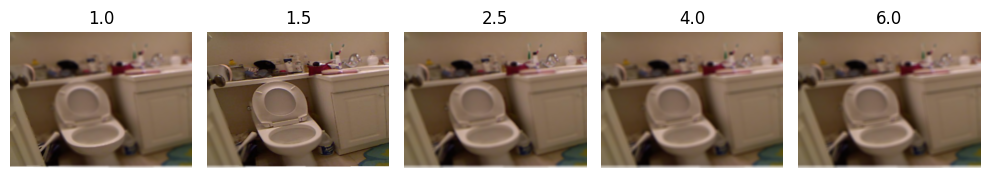

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..41.174213].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..41.518635].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..25.361746].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..22.513977].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..20.688803].


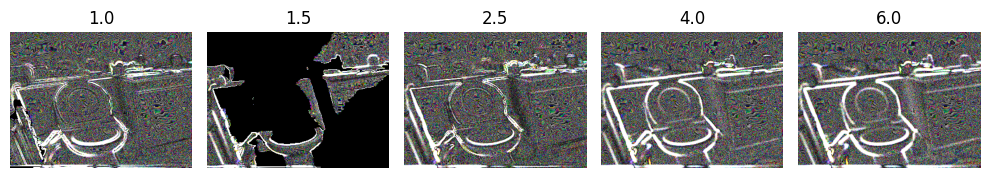

tensor(0.) tensor(1.)
MSE 4.9029408
MSE 1.3966537


In [8]:

# defocus_stack_si = forward_model.forward_torch(gt_dpt, gt_aif, op='si')
defocus_stack_si = forward_model.forward_si(gt_dpt, gt_aif)

utils.plot_single_stack(defocus_stack_si*255., globals.Df)
diff = abs(gt_defocus_stack - defocus_stack_si.numpy()*255.)
utils.plot_single_stack(diff, globals.Df, recon_max=1.5)
print(defocus_stack_si.min(), defocus_stack_si.max())
print('MSE',np.mean((defocus_stack[:,25:-25,25:-25,:]*255. - defocus_stack_si[:,25:-25,25:-25,:].numpy()*255.) ** 2))
print('MSE',np.mean((np.stack(gt_defocus_stack)[:,25:-25,25:-25,:] - np.floor(defocus_stack_si[:,25:-25,25:-25,:].numpy()*255.)) ** 2))


/tmp/ipykernel_3825159/3895294886.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff = abs(defocus_stack_si[0,:,:,2]*255. - gt_defocus_stack[0][:,:,2]).numpy()


0 255


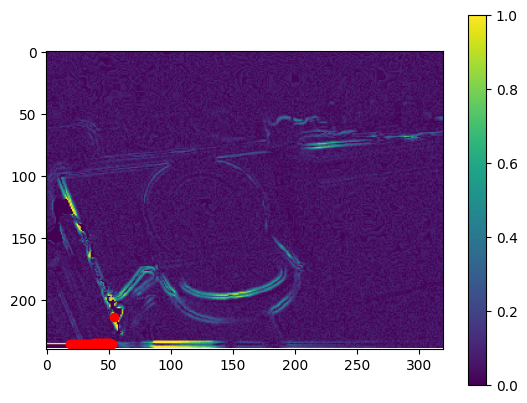

[(np.int64(214), np.int64(54))]
26.611092


In [9]:
diff = abs(defocus_stack_si[0,:,:,2]*255. - gt_defocus_stack[0][:,:,2]).numpy()
print(gt_defocus_stack[0].min(),gt_defocus_stack[0].max())


top_flat_indices = np.argsort(diff.ravel())[::-1][:50]
top_indices = [np.unravel_index(idx, diff.shape) for idx in top_flat_indices]

plt.imshow(diff, vmin=0, vmax=10)
plt.scatter([idx[1] for idx in top_indices], [idx[0] for idx in top_indices],color='red')
plt.colorbar()
plt.show()


pad = 20
top_indices = [
    np.unravel_index(idx, diff.shape)
    for idx in top_flat_indices
    if pad <= np.unravel_index(idx, diff.shape)[0] < diff.shape[0] - pad and
       pad <= np.unravel_index(idx, diff.shape)[1] < diff.shape[1] - pad
]
print(top_indices)
print(diff[214,54])


In [10]:
print('MSE',np.mean((defocus_stack[:,25:-25,25:-25,:]*255. - defocus_stack_si[:,25:-25,25:-25,:]*255.) ** 2))


TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'

In [ ]:
print(gt_defocus_stack[0][189+25,29+25])
print(np.floor(defocus_stack_v2[0,189+25,29+25]*255.))
print(gt_defocus_stack[0][189+25,29+25] - np.floor(defocus_stack_v2[0,189+25,29+25]*255.))
dx=30
plt.imshow(gt_aif[189+25-dx:189+25+dx+1,29+25-dx:29+25+dx+1])
plt.show()
print('MSE',np.mean((np.stack(gt_defocus_stack)[:,25:-25,25:-25,:] - np.floor(defocus_stack_v2[:,25:-25,25:-25,:]*255.)) ** 2))
diff = abs(np.stack(gt_defocus_stack)[:,25:-25,25:-25,:] - np.floor(defocus_stack_v2[:,25:-25,25:-25,:]*255.))
print(diff.shape)
print(diff[0,189,29])
top_indices = np.argsort(diff.ravel())[::-1][:20]
top_indices = [np.unravel_index(idx, diff.shape) for idx in top_indices]
print(top_indices)
print([diff[idx] for idx in top_indices])

In [ ]:
utils.plot_single_stack(np.stack(gt_defocus_stack)[:,0:10,0:10,:], globals.Df)
utils.plot_single_stack(defocus_stack_si[:,0:10,0:10,:], globals.Df)

utils.plot_single_stack(np.stack(gt_defocus_stack)[:,230:,105:115,:], globals.Df)
utils.plot_single_stack((defocus_stack_si[:,230:,105:115,:]*255.).int(), globals.Df)

In [ ]:
# # AIF initialization

# # aif_init = initialization.trivial_aif_initialization(defocus_stack)
# aif_init = initialization.compute_aif_initialization(defocus_stack, lmbda=0.05, sharpness_measure='sobel_grad')

# plt.imshow(defocus_stack[1]/255.)
# plt.show()

In [ ]:
# -------------------
# COORDINATE DESCENT
# -------------------

depth_init = 1#torch.median(gt_dpt.cpu()).item()
# print('initializing depth to',depth_init)

dpt, aif, ls_maxiter = coordinate_descent.coordinate_descent(width, height, defocus_stack*255., show_plots=True,
                                                 save_plots=False, num_epochs=40,
                                                 # least_squares_first=False, aif_init=aif_init,
                                                 least_squares_first=True, depth_init=depth_init,
                                                 finite_differences=False, num_Z=100, ls_maxiter=50, ls_maxiter_multiplier=1.075, 
                                                 use_CUDA=False)


In [ ]:
utils.plot_compare_rgb(aif, gt_aif)
plt.show()

utils.plot_compare_greyscale(dpt.cpu(), gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())
plt.show()

In [ ]:
# Remove outliers 

percent_outliers = 1


tv_thresh = 0.15
criterion = torch.nn.MSELoss()


while percent_outliers > 0.10: # 5-10%
    print(percent_outliers)

    dpt_no_outliers, percent_outliers = section_search.remove_outliers(dpt.cpu().numpy(), aif, tv_thresh = tv_thresh, patch_type = 'tv')
    plt.imshow(dpt_no_outliers)
    plt.show()

    tv_thresh *= 1.075
    # print(tv_thresh)

    recon = forward_model.forward_torch(torch.from_numpy(dpt_no_outliers), aif)
    loss = criterion(recon, defocus_stack_torch)
    print(loss.item())



In [ ]:
dpt, aif, ls_maxiter = coordinate_descent.coordinate_descent(width, height, defocus_stack, show_plots=False,
                                                 save_plots=False, num_epochs=40,
                                                 # least_squares_first=False, aif_init=aif_init,
                                                 least_squares_first=True, depth_init=dpt_no_outliers,
                                                 finite_differences=False, num_Z=100, ls_maxiter=ls_maxiter, ls_maxiter_multiplier=1.075, 
                                                 use_CUDA=True)

In [ ]:
utils.plot_compare_rgb(aif.cpu(), gt_aif)
plt.show()

utils.plot_compare_greyscale(dpt.cpu(), gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())
plt.show()